IMPORTING FUNCTIONS

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 6.4 MB/s 
     |████████████████████████████████| 163 kB 58.3 MB/s 
     |████████████████████████████████| 6.6 MB 81.3 MB/s 


In [4]:
# -*- coding: utf-8 -*-
import nltk
nltk.download('punkt')
import numpy as np
import re
import timeit
import csv
import random
from wsgiref import headers
from click import option
#from bigram_lm import *
from trigram_lm import *
from BERT_lm import *
import operator 
from nltk import word_tokenize as tokenize
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


There are 522 files in the training directory: drive/My Drive/ML/text-data/sentence-completion/Holmes_Training_Data


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relatio

In [5]:
import torch.nn.functional as F
import torch

ACCESSING RESOURCES

In [6]:
from gensim.models import KeyedVectors
import numpy as np
import os

#From local computer
#res_dir = "/Users/max/Desktop/NLP/Resources/"

#From Google Colab
res_dir = "drive/My Drive/ML/Resources"
embed = res_dir + "/GoogleNewsvectorsnegative300.bin"
vec = KeyedVectors.load_word2vec_format(embed, binary = True)

#From local computer
#parentdir = "/Users/max/Desktop/NLP/Resources/sentence-completion"
#question_s = "/Users/max/Desktop/NLP/Resources/sentence-completion/testing_data.csv"
#answer_s =   "/Users/max/Desktop/NLP/Resources/sentence-completion/test_answer.csv"

#From Google colab
parentdir = "drive/My Drive/ML/text-data/sentence-completion"
question_s = parentdir + "/testing_data.csv"
answer_s =   parentdir + "/test_answer.csv"

DEFINE CLASSES

In [7]:
class question():
    
    def __init__(self,aline):
        self.fields=aline
    
    def get_field(self,field):
        return self.fields[question.colnames[field]]
    
    def add_answer(self,fields):
        self.answer=fields[1]
   
    def chooseA(self):
        return("a")

    def get_tokens(self):
        return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]

    def get_tokens_2(self):
        return ["__START"]+tokenizer.tokenize(self.fields[question.colnames["question"]])+["__END"]

    def get_left_context(self,window = 1, target = "_____"):
        """Get words preceeding a target word"""
        found=-1
        sent_tokens = self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token==target:
                found=i
                break 
                
        if found>-1:
            return sent_tokens[i-window:i]
        else:
            return []
    
    def get_right_context(self,window = 1, target = "_____"):
        """Get words preceeding a target word"""
        found=-1
        sent_tokens=self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token==target:
                found=i
                break  
          
        if found>-1:
            
            return sent_tokens[found+1:found+window+1]
           
        else:
            return []

    def chooserandom(self):
        choices=["a","b","c","d","e"]
        return np.random.choice(choices)

    def replace(self,line,opt):
        "Modifies each question, and replaces the gap ____ with opt"
        line = re.sub("(_)+", opt, line)
        return line

    def get_embed(self,ans:str,vec:dict):
        """Obtains the embedding of a word from a pretrained model loaded in a dictionary, vec"""
        try:
            embed = vec[ans]
        except KeyError:
            #compound_word = re.compile(r'\D+[-]\D+') 
            embed = np.zeros(300)
            #if compound_word.search(ans):
                #tok_answer = ans.split('-') #for compound words
                #for ans in tok_answer:
                    #embed += vec[ans]
        
            pass
        return embed
        
    def predict(self,method="chooseA"):

        choices= ["a","b","c","d","e"]
        methoda = {"method" : "unigram", "smoothing":"kneser_ney" }
        methoda_1 = {"method" : "unigram", "smoothing":"none" }
        methodb = {"method" : "bigram", "smoothing":"kneser_ney" }
        methodb_2 = {"method" : "bigram", "smoothing":"none" }
        methodc = {"method" : "trigram", "smoothing":"kneser_ney" }
        methodc_2 = {"method" : "trigram", "smoothing" : "none"}
       

        headers = [str(ind) for ind,_ in question.colnames.items()]
        
    
        if method=="chooseA":
            return self.chooseA()
        else: 
            
            if method == "random": 
                choosen_option = random.randint(0,4)
                return choices[choosen_option]

            if method == "unigram":
                new_line = {opt:self.replace(self.get_field('question'), self.get_field(opt +')'))for opt in choices}
                probs = [(opt, mylm.compute_prob_line(line, methodparams = methoda)) for opt,line in new_line.items()]     
                return sorted(probs, key = operator.itemgetter(1), reverse = True)[0][0]

            if method == "bigram":
                new_line = {opt:self.replace(self.get_field('question'), self.get_field(opt +')'))for opt in choices}
                probs = [(opt, mylm.compute_prob_line(line, methodparams = methodb)) for opt,line in new_line.items()]     
                return sorted(probs, key = operator.itemgetter(1), reverse = True)[0][0]

            if method == "bigram_1":
                new_line = {opt:self.replace(self.get_field('question'), self.get_field(opt +')'))for opt in choices}
                probs = [(opt, mylm.compute_prob_line(line, methodparams = methodb_2)) for opt,line in new_line.items()]     
                return sorted(probs, key = operator.itemgetter(1), reverse = True)[0][0]


            if method == "trigram":
                probs = []
                new_line = {opt:self.replace(self.get_field('question'), self.get_field(opt +')'))for opt in choices}
                
                for opt,line in new_line.items():
                    probs.append((opt, mylm.compute_prob_line(line, methodparams = methodc),))
                    
                return sorted(probs, key = operator.itemgetter(1), reverse = False)[0][0]


            if method == "trigram_1":
                probs = []
                new_line = {opt:self.replace(self.get_field('question'), self.get_field(opt +')'))for opt in choices}
                
                for opt,line in new_line.items():
                    probs.append((opt, mylm.compute_prob_line(line, methodparams = methodc_2),))
                    
                return sorted(probs, key = operator.itemgetter(1), reverse = False)[0][0]
    
            if method == "vec":
                answer = BERT_MASK(self.get_tokens()) #finds correct answer using BERT method
                choices = ["a","b","c","d","e"]
                pos_answers = {choice: self.get_field(choice + ')') for choice in choices}
               
                if answer in pos_answers.values():
                    correct_answer = [a for a,b in pos_answers.items() if b == answer] #retrieves correct option as answer

                else:
                    embed = self.get_embed(answer,vec)
                    options_embed = {choice: self.get_embed(self.get_field( choice + ')'), vec) for choice in choices}
                    sim = [(choice, similarity(embed, near_neighbour),) for choice,near_neighbour in options_embed.items()]
                    new_answer = sorted(sim, key= operator.itemgetter(1), reverse = True)[0]
                    correct_answer = [a for a,b in pos_answers.items() if a == new_answer[0]]            
                return correct_answer[0]

            if method == "BERT":
              
                answer = BERT_MASK(self.get_tokens()) #finds correct answer using BERT method
                choices = ["a","b","c","d","e"]
                pos_answers = {choice: self.get_field(choice + ')') for choice in choices}
               
                if answer in pos_answers.values():
                    correct_answer = [a for a,b in pos_answers.items() if b == answer] #retrieves correct option as answer

                else:
                    embed = BERT_rep(self.get_tokens(), answer)
                    options_embed = {choice: BERT_rep(self.get_tokens(), self.get_field(choice + ')')) for choice in choices}
                    #Using average pooling for similarity
                    sim = [(choice, F.cosine_similarity(embed, near_neighbour).mean().item(),) for choice,near_neighbour in options_embed.items()]
                    new_answer = sorted(sim, key= operator.itemgetter(1), reverse = True)[0]
                    correct_answer = [a for a,b in pos_answers.items() if a == new_answer[0]]
                    print(f"{correct_answer},  {self.get_field(correct_answer[0] + ')')}")         
                return correct_answer[0]

            if method == "BERT-2":
              
                answer = BERT_MASK(self.get_tokens_2()) #finds correct answer using BERT method
                choices = ["a","b","c","d","e"]
                pos_answers = {choice: self.get_field(choice + ')') for choice in choices}
               
                if answer in pos_answers.values():
                    correct_answer = [a for a,b in pos_answers.items() if b == answer] #retrieves correct option as answer

                else:
                    embed = BERT_rep(self.get_tokens_2(), answer)
                    options_embed = {choice: BERT_rep(self.get_tokens_2(), self.get_field(choice + ')')) for choice in choices}
                    #Using average pooling for similarity 
                    sim = [(choice, F.cosine_similarity(embed, near_neighbour).mean().item(),) for choice,near_neighbour in options_embed.items()]
                    new_answer = sorted(sim, key= operator.itemgetter(1), reverse = True)[0]
                    correct_answer = [a for a,b in pos_answers.items() if a == new_answer[0]]
                    print(f"{correct_answer},  {self.get_field(correct_answer[0] + ')')}")         
                return correct_answer[0]

    def predict_and_score(self,method="chooseA"):
        
        #compare prediction according to method with the correct answer
        #return 1 or 0 accordingly
        prediction=self.predict(method=method)
        if prediction ==self.answer:
            return (1, prediction)
        else:
            return (0, prediction)

class scc_reader():
    
    def __init__(self,qs=question_s,ans=answer_s):
        self.qs=qs
        self.ans=ans
        self.read_files()
        
    def read_files(self):
        
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            self.qlines=list(csvreader)
        
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(self.qlines[0])}
        #id = 0, question = 1, a = 2, b =3, c =4, d =5, e=6
        
        #create a question instance for each line of the file (other than heading line)
        scc_reader.questions=[question(qline) for qline in self.qlines[1:]]
        
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
            
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)
        
    def get_field(self,field):
        return [q.get_field(field) for q in scc_reader.questions] 
    
    def predict(self,method="chooseA"):
        return [q.predict(method=method) for q in scc_reader.questions]
    
    def predict_and_score(self,method="chooseA"):
        output=[q.predict_and_score(method=method) for q in scc_reader.questions]
        scores, choice = zip(*output)
        return sum(scores)/len(scores), choice

In [8]:
SCC = scc_reader()

INTRINSIC AND EXTRINSIC EVALUATION 

In [ ]:
#Calculates accuracy and perplexity of various language models.
perplexity_tri_kn = []; perplexity_tri = [];  accuracy_tri_kn = []; accuracy_uni = []; accuracy_bi_kn = []; accuracy_bi = []; perplexity_bi_kn = []
perplexity_bi = []; accuracy_tri = [] ; perplexity_uni = []
span = range(50,500,50)

for j in span:
    mylm = language_model(trainingdir=TRAINING_DIR,files=trainingfiles[:j])
    mylm.train()
    #perplexity_tri_kn.append(mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"}))
    #perplexity_tri.append(mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"none"}))
    perplexity_bi_kn.append(mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"}))
    perplexity_bi.append(mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"}))
    perplexity_uni.append(mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"}))
    accuracy_tri_kn.append(SCC.predict_and_score(method = "trigram_1")[0])
    accuracy_tri.append(SCC.predict_and_score(method = "trigram_1")[0])
    accuracy_uni.append(SCC.predict_and_score(method =  "unigram")[0])
    accuracy_bi.append(SCC.predict_and_score(method= "bigram")[0])
    
    #accuracy_bi_kn.append(SCC.predict_and_score(method= "bigram_1")[0])

Processing GULVM10.TXT
Processing THBTC10.TXT
Processing SUTHS10.TXT
Processing 1DONQ10.TXT
Processing GMANS10.TXT
Processing TROLL10.TXT
Processing NDRTH10.TXT
Processing BLFRY10.TXT
Processing ALAMO10.TXT
Processing ASPRN10.TXT
Processing SAWY210.TXT
Processing AWILL10.TXT
Processing CHUZZ10.TXT
Processing ANNHD10.TXT
Processing NVOYG10.TXT
Processing TARZ410.TXT
Processing 80DAY10.TXT
Processing RDDSK10.TXT
Processing TTURN10.TXT
Processing IRONM10.TXT
Processing MAGOZ10.TXT
Processing MANSE10.TXT
Processing 2000010.TXT
Processing ZENDA10.TXT
Processing HHOTL10.TXT
Processing MAYRC10.TXT
Processing NARAB10.TXT
Processing HDARK11.TXT
Processing TOTAM10.TXT
Processing SONSA11.TXT
Processing VFAIR10.TXT
Processing REZNV10.TXT
Processing TCHMS10.TXT
Processing TNGLW10.TXT
UnicodeDecodeError processing TNGLW10.TXT: ignoring rest of file
Processing GMARS11.TXT
Processing TPSPD10.TXT
Processing KDSTA10.TXT
Processing SOLDF10.TXT
Processing MSBIM10.TXT
Processing ENYEW10.TXT
Processing TBTI

In [1]:
plt.plot(span, accuracy_bi, label = "Bigram")
#plt.plot(span, accuracy_bi_kn, label = "Kn_bigram")
plt.plot(span, accuracy_tri, label = "Trigram")
#plt.plot(span, accuracy_tri_kn, label = "kn_Trigram")
plt.plot(span, accuracy_uni, label = "unigram")
plt.title("Accuracy vs number of files")
plt.ylabel("Accuracy")
plt.xlabel("Number of files")
plt.legend(loc="center left")

NameError: ignored

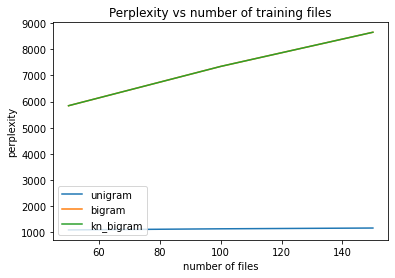

In [11]:
#plt.plot(span, perplexity_tri)
plt.plot(span, perplexity_uni, label = "unigram")
plt.plot(span, perplexity_bi, label = "bigram")
plt.plot(span, perplexity_bi_kn, label = "kn_bigram")
#plt.plot(span, perplexity_tri_kn, label = "kn_Trigram")

plt.title("Perplexity vs number of training files")
plt.ylabel("perplexity")
plt.xlabel("number of files")
plt.legend(loc="lower left")


evaluate by using embedding of either google word embeddings or glove embeddings
evaluate possible errors thst may arise from sentence structures

TRANSFER LEARNING WITH BERT AND GOOGLE 300D EMBEDDINGS - WORD TOKENIZER

In [ ]:
vec_accuracy, vec_scores = SCC.predict_and_score(method="vec")

['__START', 'I', 'have', 'it', 'from', 'the', 'same', 'source', 'that', 'you', 'are', 'both', 'an', 'orphan', 'and', 'a', 'bachelor', 'and', 'are', '_____', 'alone', 'in', 'London', '.', '__END']
['__START', 'It', 'was', 'furnished', 'partly', 'as', 'a', 'sitting', 'and', 'partly', 'as', 'a', 'bedroom', ',', 'with', 'flowers', 'arranged', '_____', 'in', 'every', 'nook', 'and', 'corner', '.', '__END']
['__START', 'As', 'I', 'descended', ',', 'my', 'old', 'ally', ',', 'the', '_____', ',', 'came', 'out', 'of', 'the', 'room', 'and', 'closed', 'the', 'door', 'tightly', 'behind', 'him', '.', '__END']
['__START', 'We', 'got', 'off', ',', '_____', 'our', 'fare', ',', 'and', 'the', 'trap', 'rattled', 'back', 'on', 'its', 'way', 'to', 'Leatherhead', '.', '__END']
['__START', 'He', 'held', 'in', 'his', 'hand', 'a', '_____', 'of', 'blue', 'paper', ',', 'scrawled', 'over', 'with', 'notes', 'and', 'figures', '.', '__END']
['__START', 'Finally', 'he', 'returned', 'to', 'the', 'pawnbroker', "'s", ',',

/content/BERT_lm.py:54: RuntimeWarning: invalid value encountered in double_scalars
  return (np.dot(vec_A,vecB)/np.sqrt((np.dot(vec_A,vec_A)+ np.dot(vecB,vecB))))


['__START', 'No', 'doubt', 'his', 'blackmailing', 'case', 'is', '_____', 'all', 'his', 'faculties', '.', '__END']
['__START', 'There', 'were', 'several', 'people', 'on', 'the', '_____', 'at', 'the', 'time', ',', 'but', 'the', 'greeting', 'appeared', 'to', 'come', 'from', 'a', 'slim', 'youth', 'in', 'an', 'ulster', 'who', 'had', 'hurried', 'by', '.', '__END']
['__START', 'This', 'we', 'have', 'now', 'been', 'doing', 'for', 'some', 'time', ',', 'and', 'in', 'order', 'to', 'help', 'us', 'in', 'our', '_____', 'we', 'erected', 'a', 'hydraulic', 'press', '.', '__END']
['__START', 'The', 'rapidity', 'with', 'which', 'such', 'a', '_____', 'would', 'take', 'effect', 'would', 'also', ',', 'from', 'his', 'point', 'of', 'view', ',', 'be', 'an', 'advantage', '.', '__END']
['__START', 'Even', 'after', 'I', 'became', 'suspicious', ',', 'I', 'found', 'it', 'hard', 'to', 'think', '_____', 'of', 'such', 'a', 'dear', ',', 'kind', 'old', 'clergyman', '.', '__END']
['__START', 'The', 'smoke', 'and', '_____

In [ ]:
vec_accuracy

0.4875

In [ ]:
BERT_accuracy, BERT_scores = SCC.predict_and_score(method="BERT")

Streaming output truncated to the last 5000 lines.
['__START', 'Now', ',', 'of', 'course', 'that', '_____', 'at', 'once', 'that', 'there', 'must', 'be', 'a', 'communication', 'between', 'the', 'two', 'rooms', '.', '__END']
['__START', 'Now', ',', 'of', 'course', 'that', '_____', 'at', 'once', 'that', 'there', 'must', 'be', 'a', 'communication', 'between', 'the', 'two', 'rooms', '.', '__END']
['d'],  suggested
['__START', 'I', 'saw', 'in', 'the', 'gaslight', 'that', 'Holmes', '_____', 'an', 'amused', 'smile', 'at', 'this', 'brilliant', 'departure', 'of', 'mine', '.', '__END']
['__START', 'I', 'saw', 'in', 'the', 'gaslight', 'that', 'Holmes', '_____', 'an', 'amused', 'smile', 'at', 'this', 'brilliant', 'departure', 'of', 'mine', '.', '__END']
['__START', 'I', 'saw', 'in', 'the', 'gaslight', 'that', 'Holmes', '_____', 'an', 'amused', 'smile', 'at', 'this', 'brilliant', 'departure', 'of', 'mine', '.', '__END']
['__START', 'I', 'saw', 'in', 'the', 'gaslight', 'that', 'Holmes', '_____', 'an'

In [ ]:
BERT_accuracy

0.5307692307692308

In [ ]:
methods = ["","random","unigram","bigram_2","bigram_l","trigram_1","trigram_2"]

for a in methods:  
    print("The score of this method {} is {}".format(a,SCC.predict_and_score(method = a)))

In [ ]:
import pandas as pd, csv

questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

with open(question_s) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)

with open (answer_s) as ans:
    ans_csv = csv.reader(ans)
    ans_lines = list(ans_csv)


qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df['correct_answer'] = ans_lines[1:]
qs_df['BERT_score'] = BERT_scores
qs_df[55:]
qs_df.style.set_properties(subset=["question"], **{"width" : "200px"})